In [1]:
import sys
import os

# Get the current working directory
current_dir = os.getcwd()

# Assuming the notebooks are in the notebooks directory and executed from there
project_root = os.path.abspath(os.path.join(current_dir, '..'))

# Add the models and src directories to the Python path
models_dir = os.path.join(project_root, 'models')
src_dir = os.path.join(project_root, 'src')

sys.path.append(models_dir)
sys.path.append(src_dir)

# Verify that the paths are correctly added
print("Current directory:", current_dir)
print("Project root directory:", project_root)
print("Models directory added to sys.path:", models_dir in sys.path)
print("Src directory added to sys.path:", src_dir in sys.path)

Current directory: d:\TESI\token_reduction_nlp\notebooks
Project root directory: d:\TESI\token_reduction_nlp
Models directory added to sys.path: True
Src directory added to sys.path: True


In [2]:
import torch
import torch.nn as nn
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2Config, AutoTokenizer, AutoModel
from modeling_topK_gpt2 import CustomGPT2LMHeadModel
import json
import matplotlib.pyplot as plt
from datasets import load_dataset
from functions import run_generation_on_dataset, plot_averages, load_custom_model
import numpy as np
import pandas as pd

d:\Conda\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
d:\Conda\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


# some trial

In [45]:
def calculate_reduction(lenght, mask):
  actual_lenght=lenght
  for percentage in mask:
    actual_lenght = (actual_lenght - int(actual_lenght*percentage))
  return actual_lenght + 1

window_sizes = [71, 50, 100, 200, 300, 500, 1000]
remaining_tokens = []
per_keep = []

mask_90 = [0.0, 0.0, 0.0, 0.0, 0.15, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

for w in window_sizes:
  #remaining_tokens.append(calculate_reduction(w, mask))
  per_keep.append(round(calculate_reduction(w, mask_90)/w,2))
  #print(remaining_tokens)
print("----------")
print(per_keep)

----------
[0.23, 0.22, 0.21, 0.2, 0.2, 0.2, 0.2]


In [46]:
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
config = GPT2Config.from_pretrained(model_name)
model_gpt = GPT2LMHeadModel.from_pretrained(model_name, config=config).to('cuda')

# Layers to prune
layers_to_prune = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

model_id = f"top_K_90"
top_K_90 =  load_custom_model(model_name, config, mask_90, selection_method="top_k", layers_to_prune=layers_to_prune)

In [7]:
# Function to generate text and calculate FLOPs
def generate_text(model, tokenizer, input_text, max_length=100):
    # tokenize the input text
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to('cuda')

    # generate text
    with torch.no_grad():
        output = model.generate(input_ids, max_length=max_length, pad_token_id=tokenizer.eos_token_id)

    # decode the generated text
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

In [47]:
generated_text = """The problem is not the problem. The problem is your attitude about the problem."""
for i in range(len(tokenizer.encode(generated_text, return_tensors='pt').to('cuda')[0])):
    print(str(i)+"--------------"+tokenizer.decode(tokenizer.encode(generated_text, return_tensors='pt').to('cuda')[0][i]))

0--------------The
1-------------- problem
2-------------- is
3-------------- not
4-------------- the
5-------------- problem
6--------------.
7-------------- The
8-------------- problem
9-------------- is
10-------------- your
11-------------- attitude
12-------------- about
13-------------- the
14-------------- problem
15--------------.


In [48]:
generated_text = generate_text(top_K_90, tokenizer, generated_text, max_length=len(tokenizer(generated_text)["input_ids"])+1)

torch.Size([1, 12, 16, 16])
torch.Size([1, 12, 16, 16])
torch.Size([1, 12, 16, 16])
torch.Size([1, 12, 16, 16])
torch.Size([1, 12, 16, 16])
tensor([[ 6,  2,  5,  4,  1,  3,  7,  9, 14,  8, 13, 11]], device='cuda:0') torch.Size([1, 16])
torch.Size([1, 12, 4, 4])
torch.Size([1, 12, 4, 4])
torch.Size([1, 12, 4, 4])
torch.Size([1, 12, 4, 4])
torch.Size([1, 12, 4, 4])
torch.Size([1, 12, 4, 4])
torch.Size([1, 12, 4, 4])


In [16]:
generated_text

'The problem is not the problem. The problem is your attitude about the problem.\n'

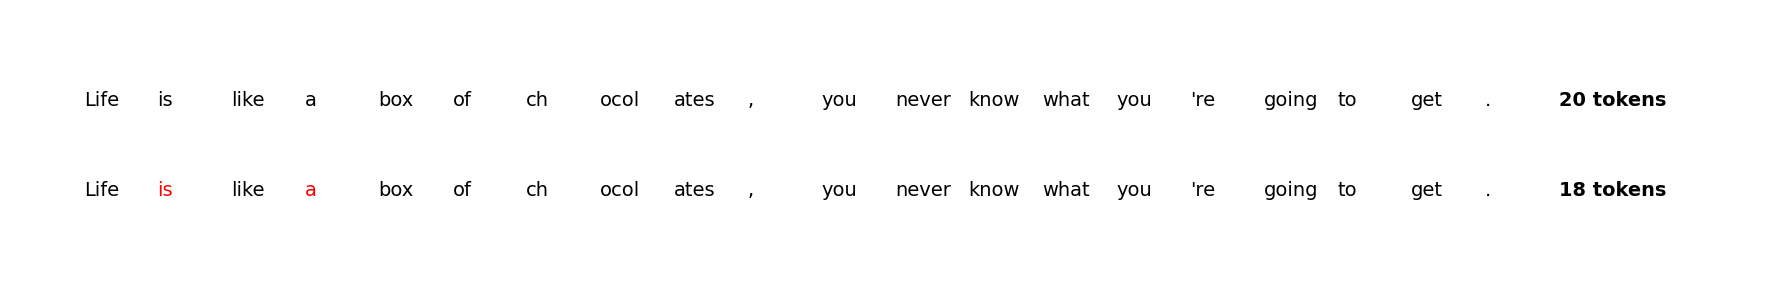

In [187]:
def create_token_removal_plot(sentence, tokens_to_remove, tokens_position='bottom'):
    tokens = sentence.split()
    total_tokens = len(tokens)
    remaining_tokens = total_tokens - len(tokens_to_remove)
    
    fig, ax = plt.subplots(figsize=(18, 3))
    
    def plot_line(y_pos, token_count, tokens_list, removed_tokens):
        for j, token in enumerate(tokens_list):
            color = 'red' if token.lower() in [t.lower() for t in removed_tokens] else 'black'
            ax.text(j, y_pos, token, ha='left', va='center', color=color, fontsize=14)
        
        token_pos = len(tokens_list) if tokens_position == 'bottom' else -1
        ax.text(token_pos, y_pos, f"{token_count} tokens", ha='left' if tokens_position == 'bottom' else 'right', 
                va='center', fontweight='bold', fontsize=14)
        ax.text(token_pos + (0.4 if tokens_position == 'bottom' else -0.4), y_pos, "", ha='center', va='center', fontsize=14)

    # Original sentence
    plot_line(1, total_tokens, tokens, [])
    
    # Sentence with removed tokens
    plot_line(0, remaining_tokens, tokens, tokens_to_remove)
    
    ax.set_ylim(-1, 2)
    ax.set_xlim(-1, len(tokens) + 3)  # Increased to accommodate token count on the right
    ax.axis('off')
    plt.tight_layout()
    plt.savefig('token_removal_plot.png')
    plt.show()

sentence = "Life is like a box of ch ocol ates , you never know what you 're going to get ."
tokens_to_remove = ["is", "a"]
#[0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
create_token_removal_plot(sentence, tokens_to_remove, tokens_position='bottom')

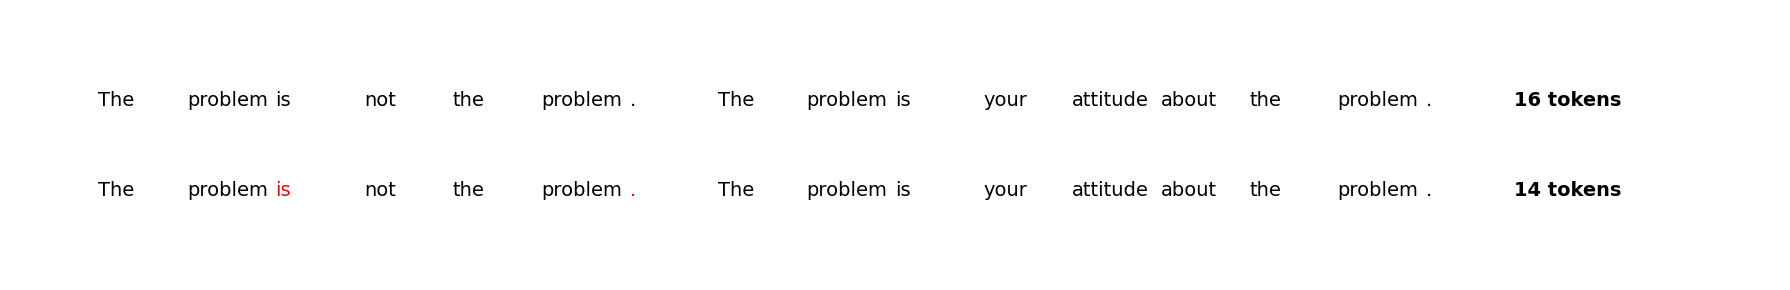

In [197]:
import matplotlib.pyplot as plt

def create_token_removal_plot(sentence, tokens_to_remove, tokens_position='bottom'):
    tokens = sentence.split()
    total_tokens = len(tokens)
    remaining_tokens = total_tokens - len(tokens_to_remove)
    
    fig, ax = plt.subplots(figsize=(18, 3))
    
    def plot_line(y_pos, token_count, tokens_list, removed_tokens):
        removed_tokens_copy = removed_tokens.copy()
        for j, token in enumerate(tokens_list):
            if token.lower() in [t.lower() for t in removed_tokens_copy]:
                color = 'red'
                removed_tokens_copy.remove(token.lower())
            else:
                color = 'black'
            ax.text(j, y_pos, token, ha='left', va='center', color=color, fontsize=14)
        
        token_pos = len(tokens_list) if tokens_position == 'bottom' else -1
        ax.text(token_pos, y_pos, f"{token_count} tokens", ha='left' if tokens_position == 'bottom' else 'right', 
                va='center', fontweight='bold', fontsize=14)
        ax.text(token_pos + (0.4 if tokens_position == 'bottom' else -0.4), y_pos, "", ha='center', va='center', fontsize=14)

    # Original sentence
    plot_line(1, total_tokens, tokens, [])
    
    # Sentence with removed tokens
    plot_line(0, remaining_tokens, tokens, tokens_to_remove)
    
    ax.set_ylim(-1, 2)
    ax.set_xlim(-1, len(tokens) + 3)  # Increased to accommodate token count on the right
    ax.axis('off')
    plt.tight_layout()
    plt.show()

sentence = "The problem is not the problem . The problem is your attitude about the problem ."
tokens_to_remove = [".", "is"]

create_token_removal_plot(sentence, tokens_to_remove, tokens_position='bottom')


In [134]:
generated_text = generate_text(top_K_90, tokenizer, generated_text, max_length=len(tokenizer(generated_text)["input_ids"])+1)

torch.Size([1, 12, 24, 24])
torch.Size([1, 12, 24, 24])
torch.Size([1, 12, 24, 24])
torch.Size([1, 12, 24, 24])
torch.Size([1, 12, 24, 24])
tensor([[7, 5]], device='cuda:0') torch.Size([1, 24])
torch.Size([1, 12, 22, 22])
torch.Size([1, 12, 22, 22])
torch.Size([1, 12, 22, 22])
torch.Size([1, 12, 22, 22])
torch.Size([1, 12, 22, 22])
torch.Size([1, 12, 22, 22])
torch.Size([1, 12, 22, 22])


In [59]:
generated_text = generate_text(top_K_90, tokenizer, generated_text, max_length=len(tokenizer(generated_text)["input_ids"])+1)

torch.Size([1, 12, 19, 19])
torch.Size([1, 12, 19, 19])
torch.Size([1, 12, 19, 19])
torch.Size([1, 12, 19, 19])
torch.Size([1, 12, 19, 19])
torch.Size([1, 12, 19, 19])
tensor([[15,  1, 14, 10,  8, 16,  3,  6,  2, 11,  7,  9, 13]], device='cuda:0') torch.Size([1, 19])
torch.Size([1, 12, 6, 6])
torch.Size([1, 12, 6, 6])
torch.Size([1, 12, 6, 6])
torch.Size([1, 12, 6, 6])
torch.Size([1, 12, 6, 6])
torch.Size([1, 12, 6, 6])


C:\Users\Angelo\AppData\Local\Temp\ipykernel_8956\827987143.py:46: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


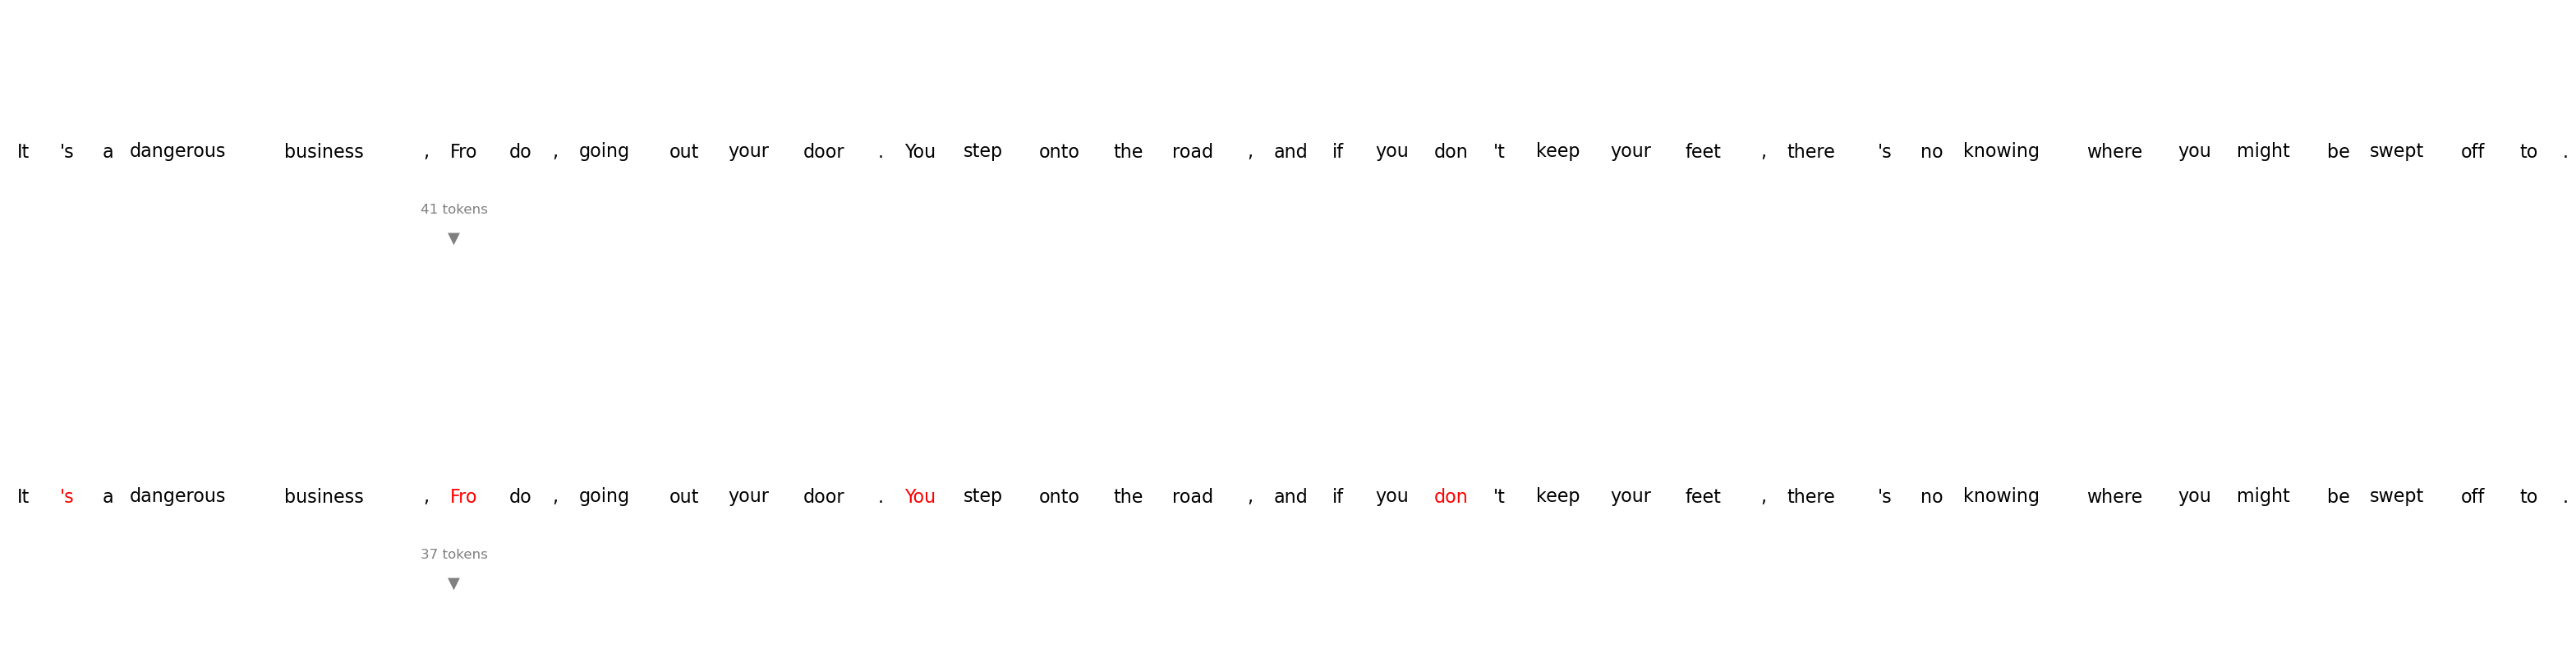

In [102]:
import matplotlib.pyplot as plt

# Define the sentence and token counts
sentence = (
    "It's a dangerous business, Frodo, going out your door. "
    "You step onto the road, and if you don't keep your feet, there's no knowing where you might be swept off to."
)
token_counts = [41, 37]  # Adjusted for the new sentence

# Define the words to be removed in each step (by indices)
removed_words_indices = [
    [],
    [1, 6, 23, 14]
]

# Define the tokens, treating punctuation as separate tokens
tokens = [
    "It", "'s", "a", "dangerous", "business", ",", "Fro", "do", ",", "going", "out", "your",
    "door", ".", "You", "step", "onto", "the", "road", ",", "and", "if",
    "you", "don", "'t", "keep", "your", "feet", ",", "there", "'s", "no",
    "knowing", "where", "you", "might", "be", "swept", "off", "to", "."
]

# Create the plot
fig, ax = plt.subplots(len(token_counts), 1, figsize=(14, 10))

for i, (count, removed_indices) in enumerate(zip(token_counts, removed_words_indices)):
    # Create the sentence with specific words in red
    colored_sentence = []
    for idx, token in enumerate(tokens):
        if idx in removed_indices:
            colored_sentence.append((token, 'red'))
        else:
            colored_sentence.append((token, 'black'))
    
    # Plot each word separately with its respective color
    x = 0.01
    for word, color in colored_sentence:
        ax[i].text(x, 0.5, word, horizontalalignment='left', verticalalignment='center', fontsize=16, color=color, transform=ax[i].transAxes)
        x += 0.018 * len(word) + 0.012  # Adjust spacing between words
    
    ax[i].text(0.5, 0.3, f"{count} tokens", horizontalalignment='center', verticalalignment='center', fontsize=12, color='grey', transform=ax[i].transAxes)
    ax[i].text(0.5, 0.2, "▼", horizontalalignment='center', verticalalignment='center', fontsize=14, color='grey', transform=ax[i].transAxes)
    ax[i].axis('off')

plt.tight_layout()
plt.show()
